<a href="https://colab.research.google.com/github/ArunK-ML/Project---Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_CNN_Val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# ========================================
#  Mount Google Drive
# ========================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install tensorflow>=2.9.0 scikit-learn matplotlib pillow streamlit numpy

In [22]:
pip install pillow matplotlib numpy pandas tqdm

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt


import random
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
from tqdm import tqdm


In [24]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Paths
TRAIN_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train"
TEST_DIR  = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/test"
VALID_DIR = "/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/valid"

# Params
image_size = 150
labels = ['glioma','meningioma','no_tumor','pituitary']

# Lists
X_train, Y_train = [], []
X_test,  Y_test  = [], []
X_val,   Y_val   = [], []

# Training Data
for i in labels:
    folderPath = os.path.join(TRAIN_DIR, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img = cv2.resize(img, (image_size,image_size))
            X_train.append(img)
            Y_train.append(i)

# Testing Data
for i in labels:
    folderPath = os.path.join(TEST_DIR, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img = cv2.resize(img, (image_size,image_size))
            X_test.append(img)
            Y_test.append(i)

# Validation Data
for i in labels:
    folderPath = os.path.join(VALID_DIR, i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        if img is not None:
            img = cv2.resize(img, (image_size,image_size))
            X_val.append(img)
            Y_val.append(i)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test  = np.array(X_test)
X_val   = np.array(X_val)

# Label encoding
y_train = [labels.index(i) for i in Y_train]
y_test  = [labels.index(i) for i in Y_test]
y_val   = [labels.index(i) for i in Y_val]

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))
y_val   = tf.keras.utils.to_categorical(y_val, num_classes=len(labels))

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Valid:", X_val.shape, y_val.shape)


Train: (1695, 150, 150, 3) (1695, 4)
Test: (246, 150, 150, 3) (246, 4)
Valid: (502, 150, 150, 3) (502, 4)


# **Understand the Dataset**

/tmp/ipython-input-3632425642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, order=labels, palette="Set2")


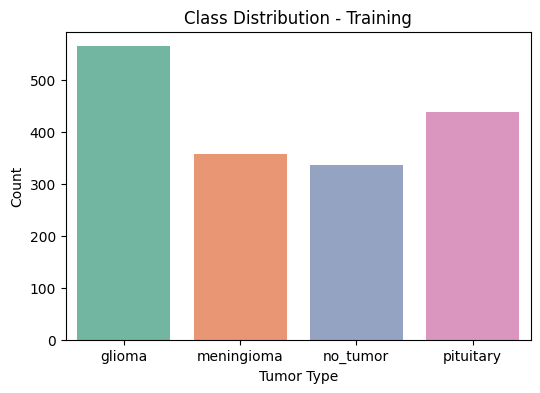

/tmp/ipython-input-3632425642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, order=labels, palette="Set2")


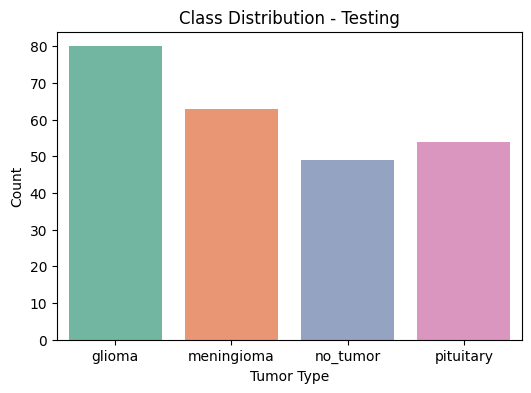

/tmp/ipython-input-3632425642.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_data, order=labels, palette="Set2")


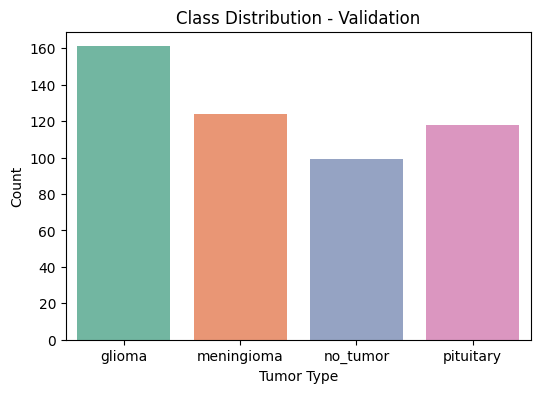

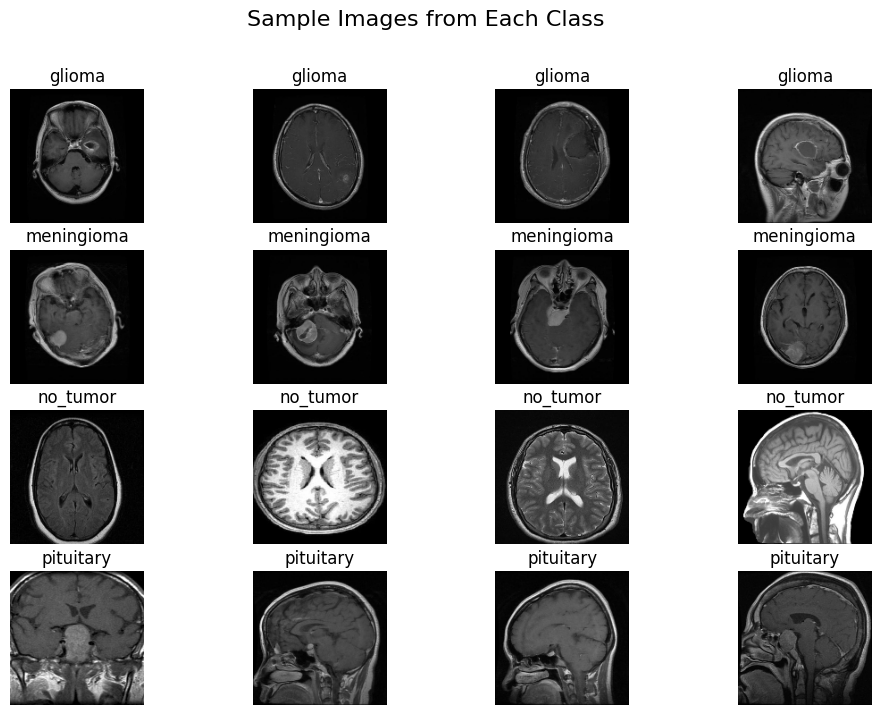

Image shape: (150, 150, 3)

Pixel intensity stats (0–1 scale):
Train - min: 0 max: 255 mean: 43.724265093411994
Test  - min: 0 max: 255 mean: 44.73530972598615
Valid - min: 0 max: 255 mean: 43.1103348089125


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Decode one-hot labels back to class names
def decode_labels(y_encoded, label_names):
    return [label_names[np.argmax(vec)] for vec in y_encoded]

y_train_decoded = decode_labels(y_train, labels)
y_test_decoded  = decode_labels(y_test, labels)
y_val_decoded   = decode_labels(y_val, labels)

# ================================
# 1. Class Distribution (Counts)
# ================================
def plot_class_distribution(y_data, dataset_name="Dataset"):
    plt.figure(figsize=(6,4))
    sns.countplot(x=y_data, order=labels, palette="Set2")
    plt.title(f"Class Distribution - {dataset_name}")
    plt.xlabel("Tumor Type")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution(y_train_decoded, "Training")
plot_class_distribution(y_test_decoded, "Testing")
plot_class_distribution(y_val_decoded, "Validation")

# ================================
# 2. Show Sample Images
# ================================
def show_sample_images(X, y_decoded, n_samples=4):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        # Pick indices of this class
        idxs = [j for j, val in enumerate(y_decoded) if val == label]
        for k in range(n_samples):
            if k < len(idxs):
                plt.subplot(len(labels), n_samples, i*n_samples + k + 1)
                plt.imshow(X[idxs[k]])
                plt.title(label)
                plt.axis("off")
    plt.suptitle("Sample Images from Each Class", fontsize=16)
    plt.show()

show_sample_images(X_train, y_train_decoded, n_samples=4)

# ================================
# 3. Image Shape & Pixel Stats
# ================================
print("Image shape:", X_train.shape[1:])  # should be (150,150,3)

print("\nPixel intensity stats (0–1 scale):")
print("Train - min:", np.min(X_train), "max:", np.max(X_train), "mean:", np.mean(X_train))
print("Test  - min:", np.min(X_test),  "max:", np.max(X_test),  "mean:", np.mean(X_test))
print("Valid - min:", np.min(X_val),   "max:", np.max(X_val),   "mean:", np.mean(X_val))


# **Data Preprocessing**

**Normalize pixel values to a 0–1 range.**


**Resize images to a consistent shape suitable for model input (e.g. 224x224 pixels).**


In [26]:
import cv2

# New target size for deep CNN models
target_size = 224

def preprocess_images(X, new_size=224):
    X_resized = []
    for img in X:
        # Resize each image
        resized = cv2.resize(img, (new_size, new_size))
        X_resized.append(resized)
    X_resized = np.array(X_resized, dtype="float32")
    # Normalize pixel values (0–255 → 0–1)
    X_resized = X_resized / 255.0
    return X_resized

# Apply preprocessing
X_train = preprocess_images(X_train, target_size)
X_test  = preprocess_images(X_test,  target_size)
X_val   = preprocess_images(X_val,   target_size)

print("✅ After preprocessing:")
print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)
print("Valid:", X_val.shape, y_val.shape)
print("Pixel range:", X_train.min(), "to", X_train.max())


✅ After preprocessing:
Train: (1695, 224, 224, 3) (1695, 4)
Test : (246, 224, 224, 3) (246, 4)
Valid: (502, 224, 224, 3) (502, 4)
Pixel range: 0.0 to 1.0


# **Model Building**

# **CNN Arch.**

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

model = Sequential()

# Block 1
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape=(target_size, target_size, 3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3),activation='relu'))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 106, 106, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 47, 47, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153,732 (4.40 MB)

 Trainable params: 1,153,732 (4.40 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)  # <-- fixed
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)  # use .keras format

# Training
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.3172 - loss: 1.3714 - val_accuracy: 0.4402 - val_loss: 1.2603 - learning_rate: 0.0010
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 194ms/step - accuracy: 0.5046 - loss: 1.1119 - val_accuracy: 0.5159 - val_loss: 1.1162 - learning_rate: 0.0010
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.6116 - loss: 0.9721 - val_accuracy: 0.5179 - val_loss: 1.0907 - learning_rate: 0.0010
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.6697 - loss: 0.8488 - val_accuracy: 0.5438 - val_loss: 1.0738 - learning_rate: 0.0010
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.6885 - loss: 0.8240 - val_accuracy: 0.5339 - val_loss: 1.1470 - learning_rate: 0.0010
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.6953 - loss: 0.7730 - val_accuracy: 0.5837 - val_loss: 1.0433 - learning_rate: 0.0010
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.7446 - loss: 0.

# **Plot**

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

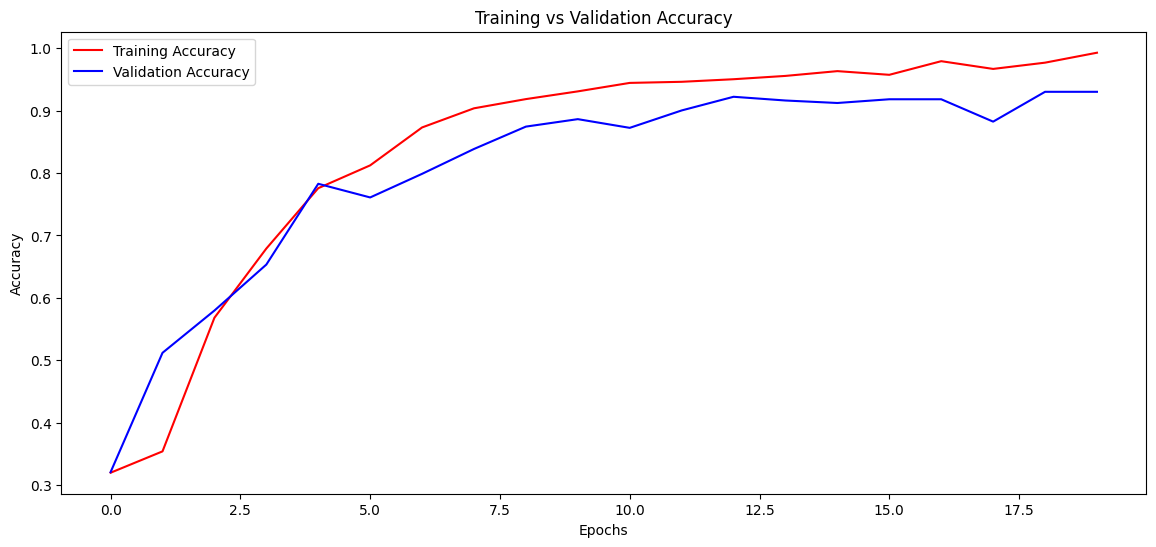

In [38]:
#model.save('braintumor.h5')
# Training history
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss    = history.history['loss']
val_loss= history.history['val_loss']
epochs  = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(14,6))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

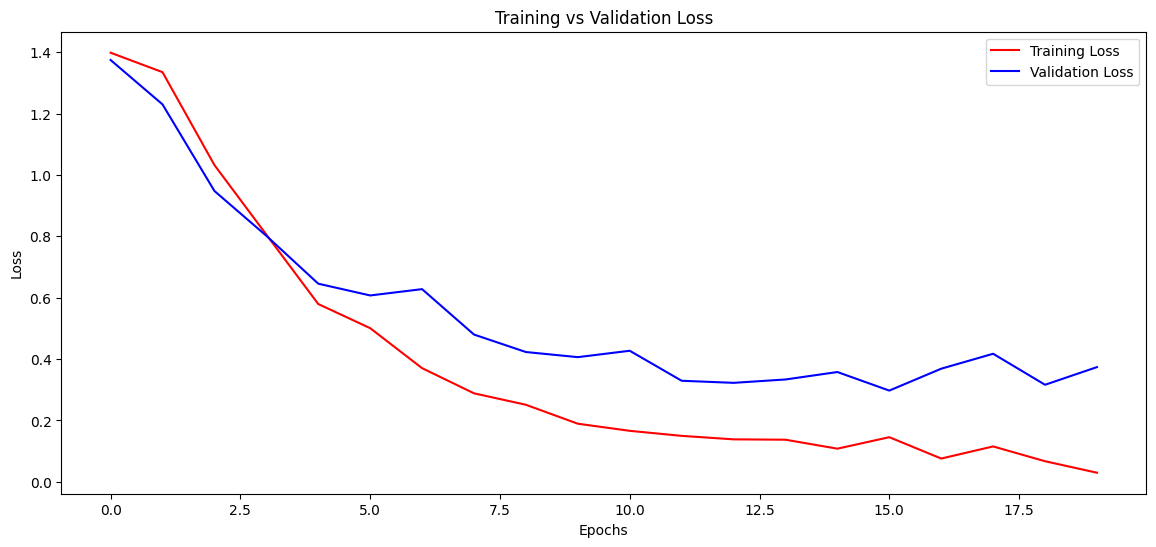

In [39]:
# Plot Loss
plt.figure(figsize=(14,6))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Evaluate on test set**

In [46]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')
# Removed precision and recall as they were not compiled metrics

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7262 - loss: 0.6290

Test accuracy: 0.6504


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# Get true classes from y_test
true_classes = np.argmax(y_test, axis=1) # Decode one-hot encoded labels to get class indices

# Get predictions on the test set
predictions = model.predict(X_test)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=labels))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.63      0.95      0.76        80
  meningioma       0.62      0.21      0.31        63
    no_tumor       0.75      0.49      0.59        49
   pituitary       0.64      0.87      0.74        54

    accuracy                           0.65       246
   macro avg       0.66      0.63      0.60       246
weighted avg       0.66      0.65      0.61       246


Confusion Matrix:
[[76  2  0  2]
 [35 13  8  7]
 [ 2  6 24 17]
 [ 7  0  0 47]]


# **`VGG16 Evaluation`**

In [59]:
def evaluate_vgg16(train_dir, val_dir):
    # Import necessary libraries inside the function
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping

    # Data generators setup
    img_size = (224, 224)
    batch_size = 32

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        horizontal_flip=True
    )
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    num_classes = len(train_generator.class_indices)
    class_names = list(train_generator.class_indices.keys())

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [62]:
# Results storage
model_comparison = []

# Define data directories
train_dir = '/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train'
val_dir = '/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/valid'

vgg_model, vgg_history = evaluate_vgg16(train_dir, val_dir)
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2918 - loss: 1.5159 - precision: 0.3870 - recall: 0.0152 - val_accuracy: 0.5060 - val_loss: 1.2282 - val_precision: 1.0000 - val_recall: 0.0159
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 658ms/step - accuracy: 0.4828 - loss: 1.2192 - precision: 0.8757 - recall: 0.0752 - val_accuracy: 0.5996 - val_loss: 1.0955 - val_precision: 0.8846 - val_recall: 0.1833
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 667ms/step - accuracy: 0.5862 - loss: 1.0803 - precision: 0.8995 - recall: 0.1886 - val_accuracy: 0.6414 - val_loss: 1.0109 - val_precision: 0.8268 - val_recall: 0.2092
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 728ms/step - accuracy: 0.6363 - loss: 0.9911 - precision: 0.8726 - recall: 0.2502 - val_accuracy: 0.6833 - val_loss: 0.9485 - val_precision: 0.8333 - val_recall: 0.2689
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 703ms/step - accuracy: 0.6533 - loss: 0.9584 - precision: 0.8483 - recall: 0.3018 - val_accuracy: 0.6673 - val_loss: 

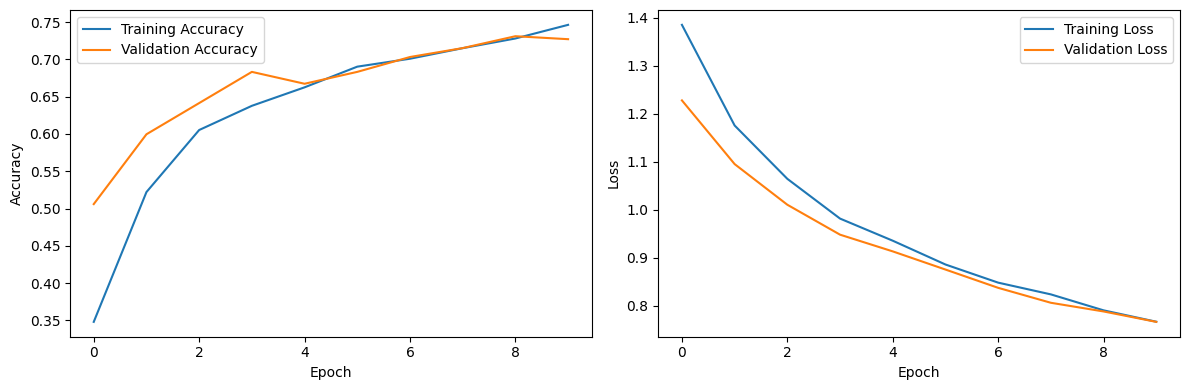

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7460 - loss: 0.6806 - precision: 0.8910 - recall: 0.5706

Test accuracy: 0.7276
Test precision: 0.8732
Test recall: 0.5041
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


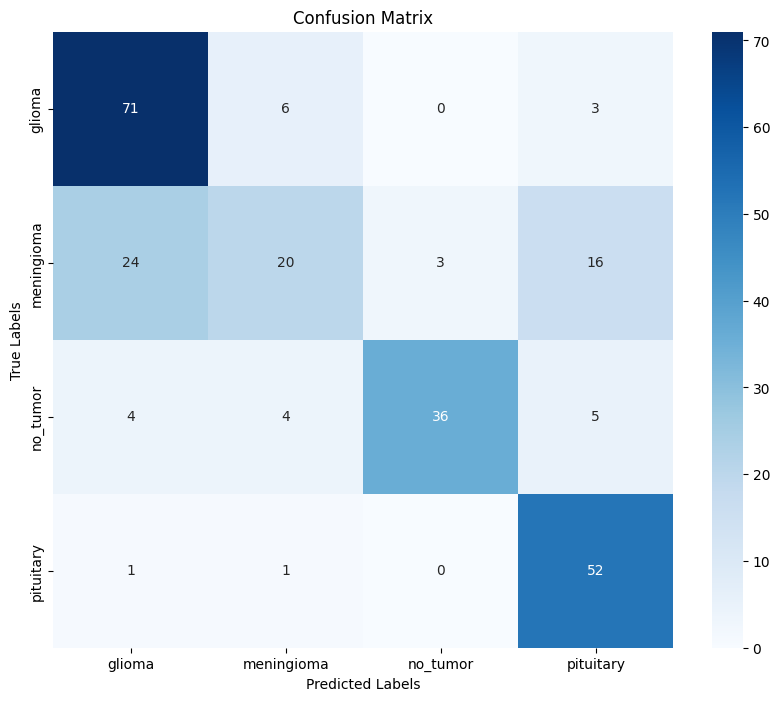

In [65]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)

# Define class_names
class_names = labels


# Evaluate on test set using X_test and y_test
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions using X_test
predictions = vgg_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes from y_test
true_classes = np.argmax(y_test, axis=1)


# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **ResNet50 Evaluation**



In [68]:
def evaluate_resnet50():
    # Import necessary libraries inside the function
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping

    # Data generators setup (Assuming train_dir and val_dir are accessible)
    img_size = (224, 224)
    batch_size = 32

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        horizontal_flip=True
    )
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    num_classes = len(train_generator.class_indices)
    class_names = list(train_generator.class_indices.keys())

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [69]:


resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 883ms/step - accuracy: 0.3367 - loss: 1.3839 - precision: 0.4277 - recall: 0.0397 - val_accuracy: 0.4522 - val_loss: 1.2379 - val_precision: 0.7778 - val_recall: 0.0418
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 57s 570ms/step - accuracy: 0.4336 - loss: 1.2632 - precision: 0.6806 - recall: 0.0899 - val_accuracy: 0.4382 - val_loss: 1.2376 - val_precision: 0.8333 - val_recall: 0.0598
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.4850 - loss: 1.1977 - precision: 0.7597 - recall: 0.1105 - val_accuracy: 0.5060 - val_loss: 1.1753 - val_precision: 0.8378 - val_recall: 0.0618
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 590ms/step - accuracy: 0.4732 - loss: 1.1994 - precision: 0.7414 - recall: 0.1314 - val_accuracy: 0.5797 - val_loss: 1.1269 - val_precision: 0.8043 - val_recall: 0.0737
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 572ms/step - accuracy: 0.5263 - loss: 1.1455 - precision: 0.7623 - recall: 0.1328 - val_accuracy: 0.5398 - val_los

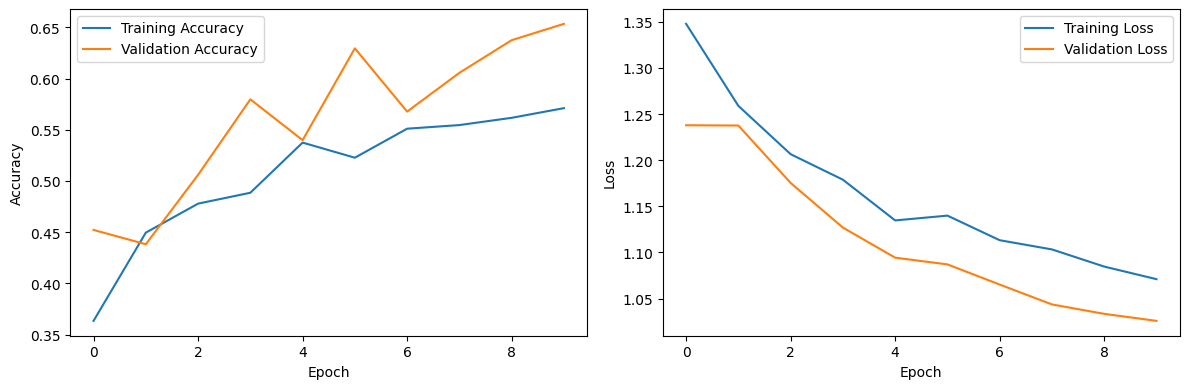

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6850 - loss: 0.9717 - precision: 0.7977 - recall: 0.2860

Test accuracy: 0.5691
Test precision: 0.7000
Test recall: 0.1992
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 655ms/step


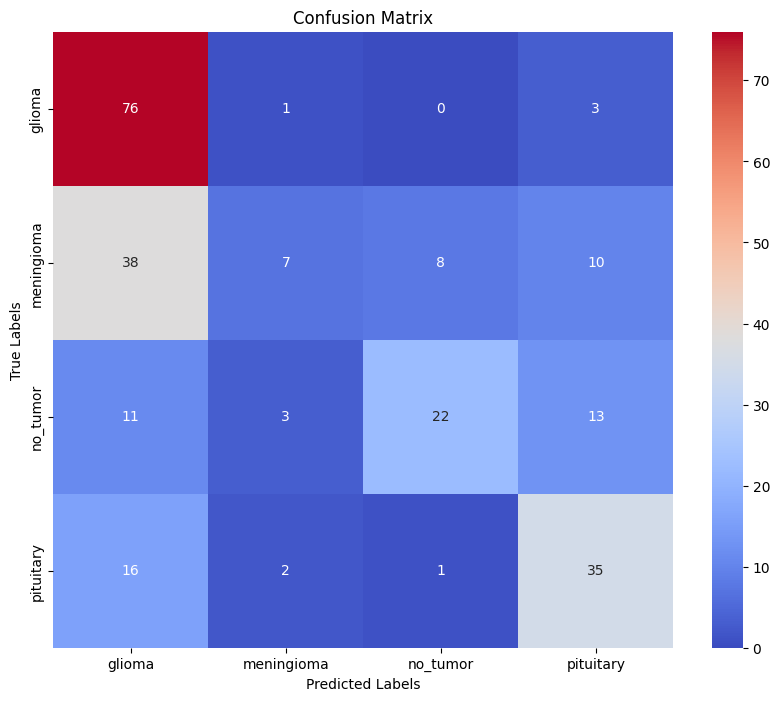

In [71]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(resnet_history)

# Define class_names
class_names = labels

# Evaluate on test set (assuming you have a test_generator)
test_loss, test_acc, test_precision, test_recall = resnet_model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = resnet_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **MobileNet Evaluation**

In [74]:
def evaluate_mobilenet():
    # Import necessary libraries inside the function
    from tensorflow.keras.applications import MobileNet
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping

    # Data generators setup (Assuming train_dir and val_dir are accessible)
    img_size = (224, 224)
    batch_size = 32

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        horizontal_flip=True
    )
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    num_classes = len(train_generator.class_indices)
    class_names = list(train_generator.class_indices.keys())

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [75]:
mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 940ms/step - accuracy: 0.4754 - loss: 1.2943 - precision: 0.5576 - recall: 0.3472 - val_accuracy: 0.7649 - val_loss: 0.6021 - val_precision: 0.8182 - val_recall: 0.6813
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - accuracy: 0.7410 - loss: 0.6261 - precision: 0.8375 - recall: 0.6793 - val_accuracy: 0.8247 - val_loss: 0.4687 - val_precision: 0.8603 - val_recall: 0.7849
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.8218 - loss: 0.4470 - precision: 0.8688 - recall: 0.7808 - val_accuracy: 0.8526 - val_loss: 0.3937 - val_precision: 0.8927 - val_recall: 0.8287
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 544ms/step - accuracy: 0.8403 - loss: 0.4069 - precision: 0.8629 - recall: 0.8069 - val_accuracy: 0.8606 - val_loss: 0.3820 - val_precision: 0.8910 - val_recall: 0.8307
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 551ms/step - accuracy: 0.8770 - loss: 0.3373 - precision: 0.9024 - recall: 0.8536 - val_accuracy: 0.8884 - val_los

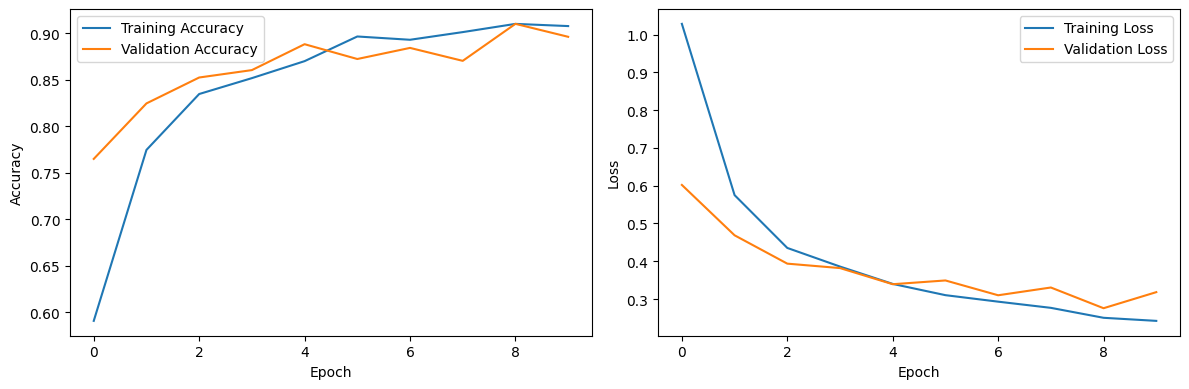

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8663 - loss: 0.3255 - precision: 0.8811 - recall: 0.8619

MobileNet Test accuracy: 0.8699
MobileNet Test precision: 0.8797
MobileNet Test recall: 0.8618
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step


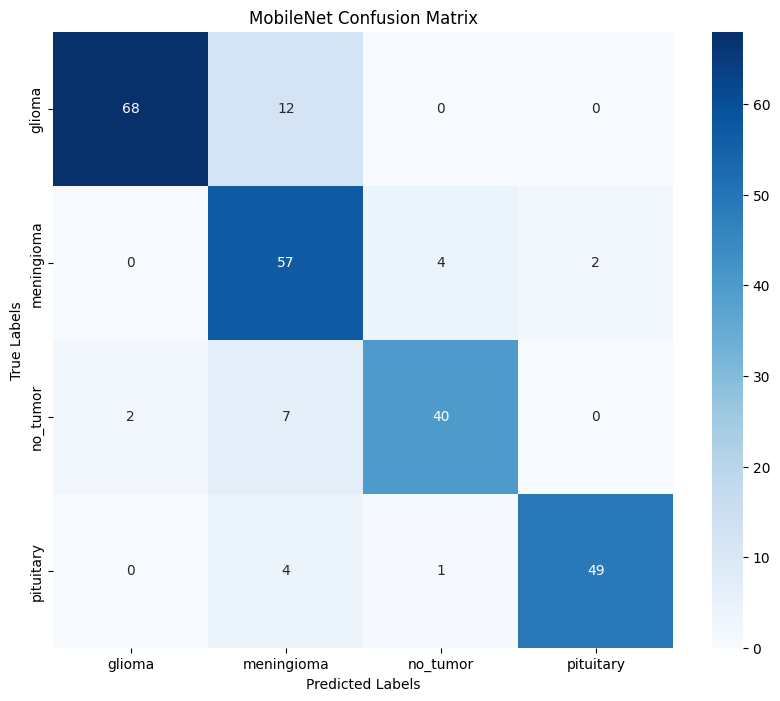

In [77]:
# Plot training history for MobileNet
plot_history(mobilenet_history)

# Define class_names
class_names = labels

# Evaluate on test set for MobileNet using X_test and y_test
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(X_test, y_test)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet using X_test
predictions = mobilenet_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet from y_test
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

# **InceptionV3 Evaluation**

In [80]:
def evaluate_inception():
    # Import necessary libraries inside the function
    from tensorflow.keras.applications import InceptionV3
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping

    # Data generators setup (Assuming train_dir and val_dir are accessible)
    img_size = (299, 299) # InceptionV3 expects 299x299 input
    batch_size = 32

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        horizontal_flip=True
    )
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    # Special generator for Inception's 299x299 input
    inception_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
    inception_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

    num_classes = len(inception_train_gen.class_indices)
    class_names = list(inception_train_gen.class_indices.keys())


    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        inception_train_gen,
        validation_data=inception_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [81]:
inception_model, inception_history = evaluate_inception()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Multi-scale features'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.3908 - loss: 1.3031 - precision: 0.5844 - recall: 0.0546 - val_accuracy: 0.4861 - val_loss: 1.1488 - val_precision: 0.7841 - val_recall: 0.1375
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 859ms/step - accuracy: 0.5078 - loss: 1.1656 - precision: 0.7398 - recall: 0.1679 - val_accuracy: 0.5876 - val_loss: 1.1113 - val_precision: 0.7232 - val_recall: 0.1614
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 48s 905ms/step - accuracy: 0.5756 - loss: 1.0940 - precision: 0.7611 - recall: 0.2145 - val_accuracy: 0.6036 - val_loss: 1.0201 - val_precision: 0.8026 - val_recall: 0.2430
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 861ms/step - accuracy: 0.5656 - loss: 1.0729 - precision: 0.7376 - recall: 0.2394 - val_accuracy: 0.6155 - val_loss: 0.9845 - val_precision: 0.7811 - val_recall: 0.3127
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 861ms/step - accuracy: 0.5856 - loss: 1.0395 - precision: 0.7218 - recall: 0.2770 - val_accuracy: 0.6653 - val_loss: 

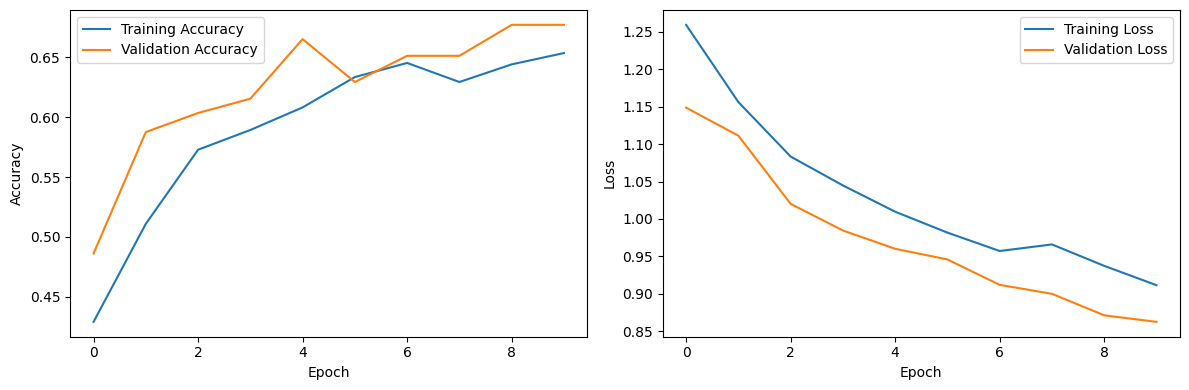

Found 246 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6136 - loss: 0.9038 - precision: 0.7262 - recall: 0.4121

Test accuracy: 0.6382
Test precision: 0.7582
Test recall: 0.4715


8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


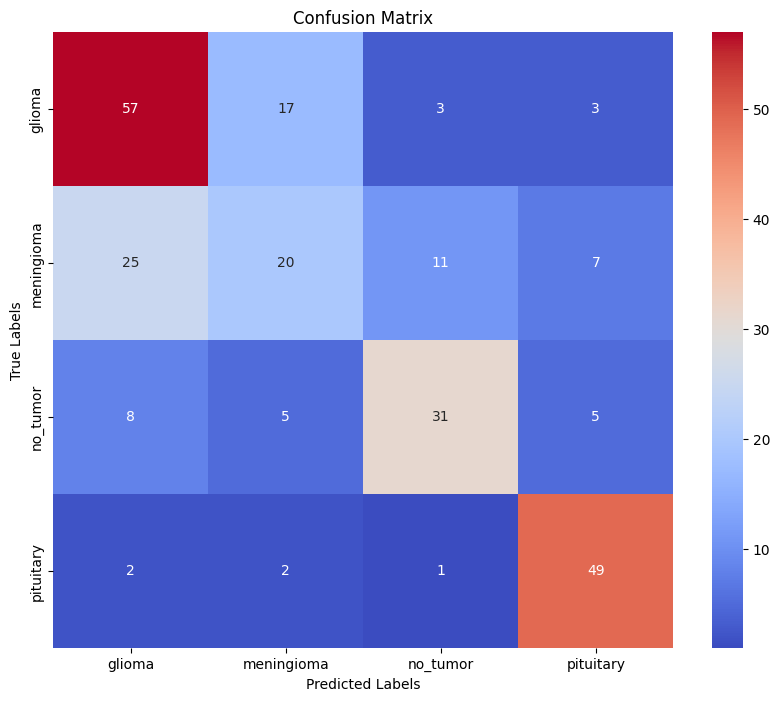

In [83]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf # Import tensorflow

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(inception_history)

# Define necessary variables
test_dir = '/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/test'
batch_size = 32 # Define batch_size
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # Define val_datagen
class_names = labels # Define class_names


# Create a test generator specifically for InceptionV3 with target size (299, 299)
inception_test_gen = val_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)


# Evaluate on test set (assuming you have a test_generator)
inception_test_gen.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = inception_model.evaluate(inception_test_gen)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = inception_model.predict(inception_test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = inception_test_gen.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **EfficientNetB0 Evaluation**

In [86]:
def evaluate_efficientnet():
    # Import necessary libraries inside the function
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    import tensorflow as tf # Ensure tf is imported

    # Data generators setup (Assuming train_dir and val_dir are accessible)
    img_size = (224, 224)
    batch_size = 32

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        horizontal_flip=True
    )
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    num_classes = len(train_generator.class_indices)
    class_names = list(train_generator.class_indices.keys())


    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

In [87]:
efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.3137 - loss: 1.3853 - precision: 0.2709 - recall: 0.0016 - val_accuracy: 0.3207 - val_loss: 1.3735 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 551ms/step - accuracy: 0.3036 - loss: 1.3861 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3827 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 548ms/step - accuracy: 0.3119 - loss: 1.3749 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3769 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 561ms/step - accuracy: 0.3096 - loss: 1.3869 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3769 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


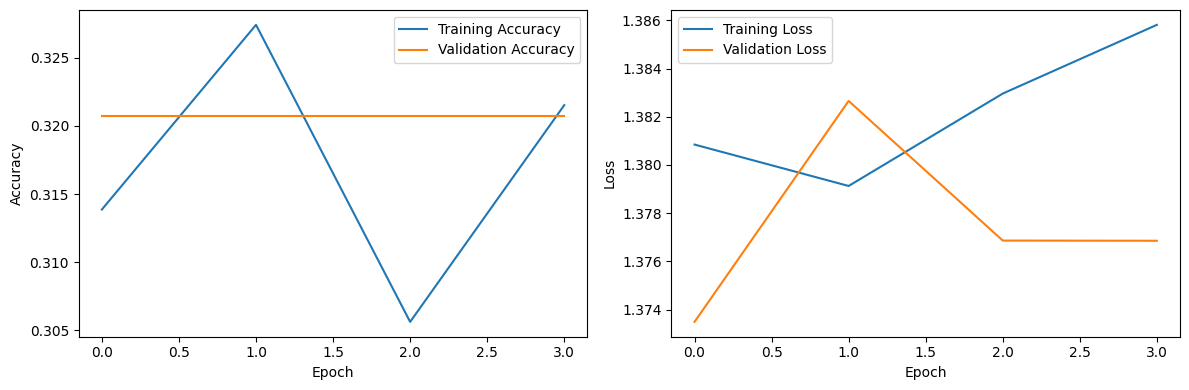

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5981 - loss: 1.2514 - precision: 0.0000e+00 - recall: 0.0000e+00

Test accuracy: 0.3252
Test precision: 0.0000
Test recall: 0.0000


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 897ms/step


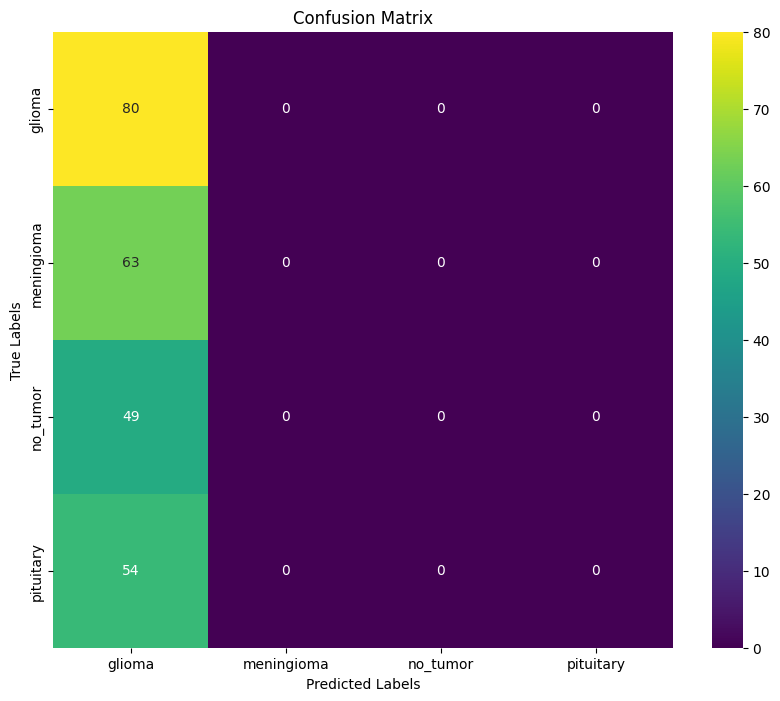

In [89]:
#training history and confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(efficientnet_history)

# Define class_names
class_names = labels

# Evaluate on test set (assuming you have a test_generator)
test_loss, test_acc, test_precision, test_recall = efficientnet_model.evaluate(X_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = efficientnet_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Results Comparison**

In [90]:
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])


,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.910359,0.918699,0.900398,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.731076,1.000000,0.503984,"14,716,740",Medium,Medium-sized datasets
3,InceptionV3,0.677291,0.806122,0.484064,"21,810,980",Medium,Multi-scale features
1,ResNet50,0.653386,0.856000,0.306773,"23,595,908",Medium,General purpose
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.910359
Val Precision                0.918699
Val Recall                   0.900398
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 2, dtype: object


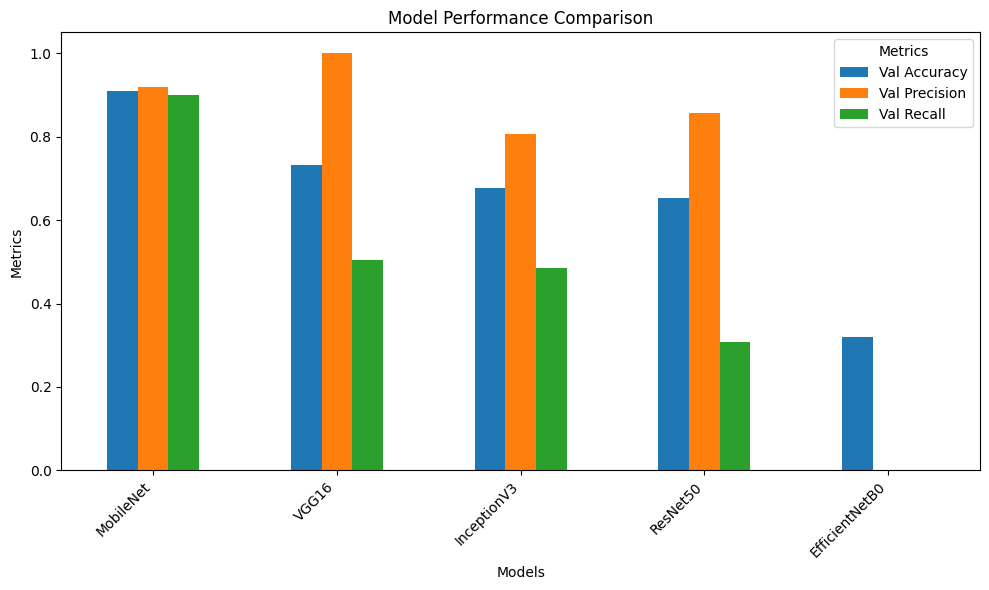

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the existing comparison_df DataFrame instead of reading from a file
# df = pd.read_csv('/content/Vasanth_P/MyDrive/Project_4_Brain_Tumor_MRI_Image_Classification/dataset/model_comparison.csv')

# Find the best model based on validation accuracy
best_model = comparison_df.loc[comparison_df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
comparison_df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# **SAVE MODEL**

In [ ]:
model.save("braintumor.h5")
print("Model saved successfully 🚀")

# **Test the Model**

check 1 - meningioma

In [93]:
img = cv2.imread('/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/meningioma/Tr-me_0551_jpg.rf.58c4d99195ebc75bb6af47123a856a97.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [94]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

In [95]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


np.int64(2)

check2 - glioma

In [96]:
img = cv2.imread('/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/glioma/Tr-gl_0019_jpg.rf.6402e96f1a18221808a378aece0b4a5d.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [97]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

In [98]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


np.int64(2)

check3- no tumor

In [99]:
img = cv2.imread('/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/no_tumor/Tr-no_0021_jpg.rf.660b878cd731bac20110b5135365001d.jpg')
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [100]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

In [101]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


np.int64(2)

check 4 - pituitary

In [102]:
img = cv2.imread("/content/drive/MyDrive/Project_DataSets_GUVI/Tumour-20250909T193851Z-1-001/Tumour/train/pituitary/Tr-pi_0029_jpg.rf.2750d010652f4fd08d1c7049890817b7.jpg")
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array.shape

(150, 150, 3)

In [103]:
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

In [104]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


np.int64(2)